

<img src="assets/eg3.jpg", alt="Photo of Midwestern Home", height="200", width="300">

# Using Supervised Machine Learning to Predict Home Prices

** Author: Jackie Zuker **

** June 2017 **



## Introduction to the Dataset

This dataset comes from the Ames, Iowa Assessor's office and includes various features of homes sold between 2006 and 2010 within the community.

The Ames Housing dataset is comprised of 2930 observations (1460 included in the training dataset) across 82 variables. There are 23 nominal variables, 23 ordinal variables, 14 discrete, and 20 continuous variables. 

**Question of interest: Can the sales price of a home be predicted?** 

Before diving into the statistical analysis, let's get oriented to our dataset. First we see a histogram of the distribution of sales prices of the homes in the dataset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from scipy import stats

%matplotlib inline

In [2]:
homePricesTrain = pd.read_csv("/Users/jacquelynzuker/Desktop/DataScienceBootcamp/Capstone/train.csv")
print("Dimensions of homePricesTrain: ", homePricesTrain.shape)
homePricesTest = pd.read_csv("/Users/jacquelynzuker/Desktop/DataScienceBootcamp/Capstone/test.csv")
print("Dimensions of homePricesTest: ", homePricesTest.shape)

# Set the label of Sale Price to its own variable. 
label = homePricesTrain['SalePrice']
homePricesTrain['Group'] = 'train'
homePricesTest['Group'] = 'test'

# Concatenate the test and training sets so that all feature engineering, data cleaning, etc is applied to both groups.
frames = [homePricesTrain, homePricesTest]
homePrices = pd.concat(frames)
homePricesPCA = homePrices

Dimensions of homePricesTrain:  (1460, 81)
Dimensions of homePricesTest:  (1459, 80)


#### Distribution of Sale Prices

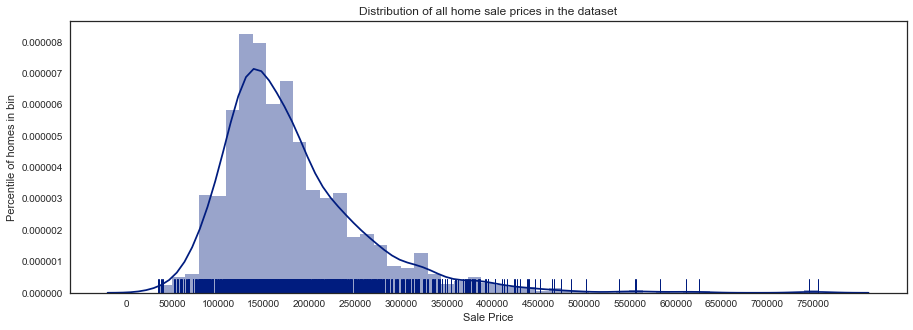

In [3]:
# Histogram of home prices
sns.set(style="white", palette="dark")
plt.figure(figsize=(15,5))
sns.distplot(homePricesTrain["SalePrice"], kde=True, rug=True);
plt.title("Distribution of all home sale prices in the dataset")
plt.xlabel("Sale Price")
plt.ylabel("Percentile of homes in bin")
plt.xticks(np.arange(0, max(homePricesTrain["SalePrice"])+1000, 50000))
plt.show()

#### Neighborhoods

Next we see the general breakdown in the dataset by volume of homes sold and by neighborhood. We can see that the Neighborhood is an important factor of the sale price of the home. 
* ***NridgeHt*** and ***NoRidge homes*** have the highest median Sales prices as well as highest outliers
* ***NAmes*** and ***CollgCr*** neighborhoods had the greatest volume of homes sold during the 4-year period. 


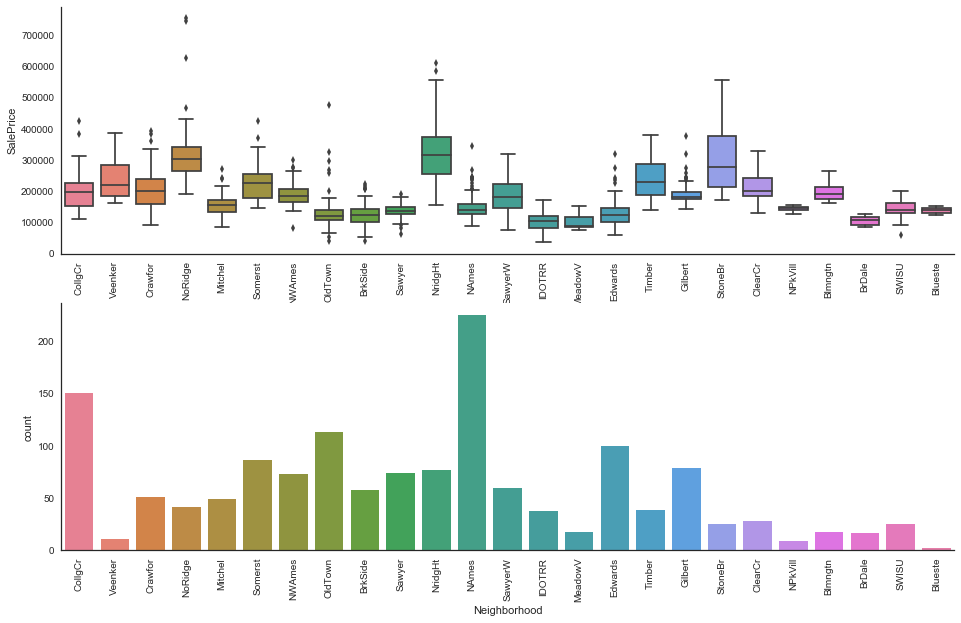

In [4]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(16,10))
sns.despine(left=False)

sns.boxplot("Neighborhood","SalePrice",data=homePricesTrain, palette="husl", ax=ax1)
sns.countplot(x="Neighborhood", data=homePricesTrain, palette="husl", ax=ax2)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

plt.show()

#### Categorical variables

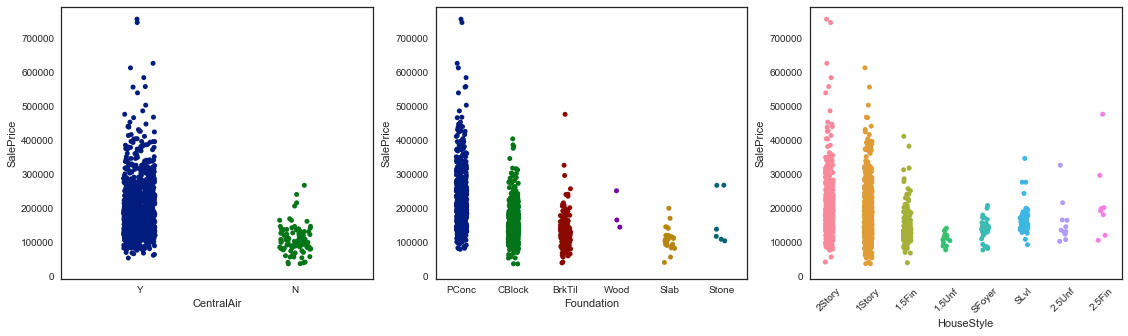

In [5]:
sns.set(style = "white", palette = "dark")
fig, axs = plt.subplots(ncols=3, figsize = (19,5))
plt.xticks(rotation = 45)
sns.stripplot(x = homePricesTrain["CentralAir"], y = homePricesTrain["SalePrice"],jitter = True, ax = axs[0])
sns.stripplot(x = homePricesTrain["Foundation"], y = homePricesTrain["SalePrice"],jitter = True, ax = axs[1])
sns.stripplot(x = homePricesTrain["HouseStyle"], y = homePricesTrain["SalePrice"],jitter = True, ax = axs[2])
plt.show()

It looks like there is some correlation with higher sale price and central air. Additionally, we see correlations with the sale price and various foundation types, and various house Styles. 

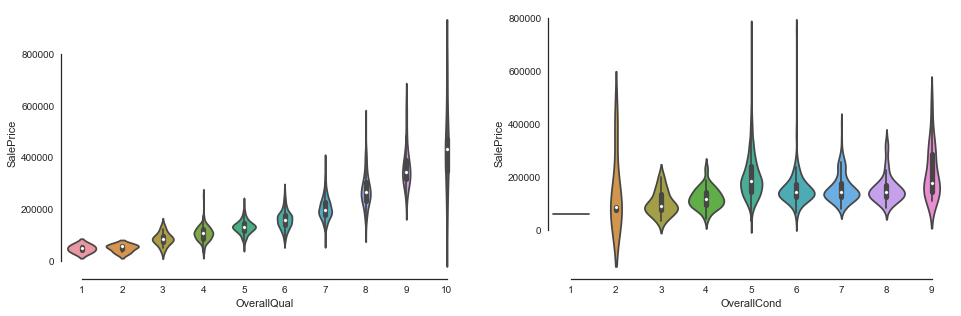

In [6]:
fig, axs = plt.subplots(ncols = 2, figsize = (16,5))
sns.violinplot("OverallQual","SalePrice",data = homePricesTrain, ax = axs[0])
sns.violinplot("OverallCond","SalePrice",data = homePricesTrain, ax = axs[1])

sns.despine(trim = True)

As the Overall Quality score increases, there is a positive correlation with the Sale Price. Interestingly, we do not see as strong of a correlation in the Overall Condition variable. 


# Modelling and Prediction

## Data Cleaning

**Missing Value Imputation:**

The first step is to deal with any missing values. The following variables have more than 15% of the values missing or NaN. 

In [7]:
del homePrices["SalePrice"]

nans = pd.isnull(homePrices).sum()
missing = nans[nans>(len(homePrices)*.15)]
missing = list(missing.index)
print(missing)

['Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'MiscFeature', 'PoolQC']


For the variables that are categorical, we can replace a value "None" with the existing N/A. This will allow the model to treat "None" as another category. This is especially useful for a field like "MiscFeature", which includes second garages, large sheds, and other features that may affect the property value. For the numerical feature "LotFrontage", it makes more sense to remove this feature than to replace the field with '0'. 

In [8]:
homePrices.Alley.fillna(value="None", axis = 'index', inplace=True)
homePrices.Fence.fillna(value="None", axis = 'index', inplace=True)
homePrices.FireplaceQu.fillna(value="None", axis = 'index', inplace=True)
homePrices.MiscFeature.fillna(value="None", axis = 'index', inplace=True)
homePrices.PoolQC.fillna(value="None", axis = 'index', inplace=True)

homePrices.drop("LotFrontage", axis = 1, inplace=True)

nans=pd.isnull(homePrices).sum()
missing = nans[nans>(len(homePrices)*.15)]
missing = list(missing.index)
homePrices.drop(homePrices[missing], axis = 1, inplace = True)
print(missing)

# Next let's investigate which NaN values remain, and how many there are in each category: # 
nans = pd.isnull(homePrices).sum()
nans[nans > 0] 


[]


BsmtCond         82
BsmtExposure     82
BsmtFinSF1        1
BsmtFinSF2        1
BsmtFinType1     79
BsmtFinType2     80
BsmtFullBath      2
BsmtHalfBath      2
BsmtQual         81
BsmtUnfSF         1
Electrical        1
Exterior1st       1
Exterior2nd       1
Functional        2
GarageArea        1
GarageCars        1
GarageCond      159
GarageFinish    159
GarageQual      159
GarageType      157
GarageYrBlt     159
KitchenQual       1
MSZoning          4
MasVnrArea       23
MasVnrType       24
SaleType          1
TotalBsmtSF       1
Utilities         2
dtype: int64

The Garage and Basement variables which are currently NaNs were also found to be the Garages and Basements with 0 square footage. The NaN's were replaced with the string "None" for further analysis. The GarageYearBlt is directly correlated with the Home year built, and there was no easy way to impute the NaN's, so this column was dropped. 

The remaining variables are replaced with mean values for the discrete fields, and mode values for the categorical fields.


In [9]:
homePrices.GarageCond.fillna(value="None", axis = 'index', inplace=True)
homePrices.GarageFinish.fillna(value="None", axis = 'index', inplace=True)
homePrices.GarageQual.fillna(value="None", axis = 'index', inplace=True)
homePrices.GarageType.fillna(value="None", axis = 'index', inplace=True)

homePrices['BsmtCond'].fillna(value="None", axis = 'index', inplace=True)
homePrices['BsmtExposure'].fillna(value="None", axis = 'index', inplace=True)
homePrices['BsmtFinType1'].fillna(value="None", axis = 'index', inplace=True)
homePrices['BsmtFinType2'].fillna(value="None", axis = 'index', inplace=True)
homePrices['BsmtQual'].fillna(value="None", axis = 'index', inplace=True)

homePrices = homePrices.drop("GarageYrBlt", 1)

# Replaces NAs in scalar fields with the mean value
homePrices = homePrices.fillna(homePrices.mean())

nans = pd.isnull(homePrices).sum()
stillmissing = nans[nans>0]
stillmissing = stillmissing.index

# Replaces NAs in categorical fields with the mode value
for feature in stillmissing:
    homePrices.loc[(homePrices[feature].isnull()), feature] = str(homePrices[feature].mode())
    
nans = pd.isnull(homePrices).sum()
nans[nans > 0]

Series([], dtype: int64)

** All missing values have been imputed. **



## Feature Engineering

### Feature Selection and Filtering

#### Logged Sale Price

As previously observed, the distribution of Sale Prices is right-skewed. One basic assumption of Linear Regression is that all variables are normally distributed. Introducing a variable, log of Sale Price is likely to yield a better model. 


In [10]:
logged_label = np.log(label)

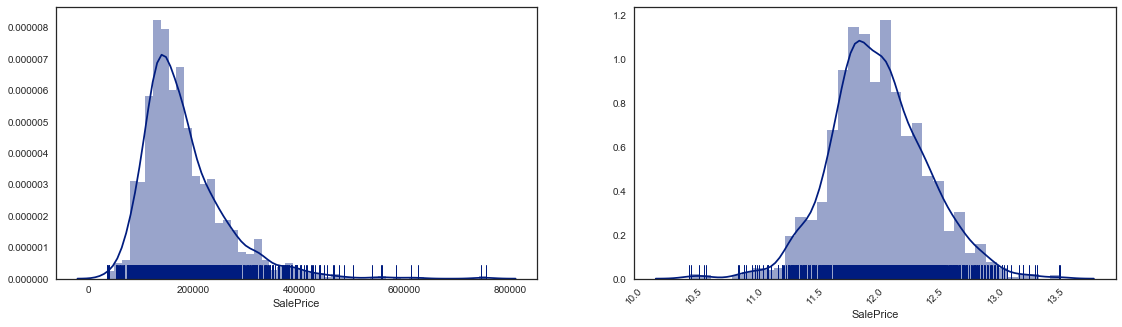

In [11]:
# Compare the distributiona of Sale Price versus logged Sale Price. The logged Sale Price is more normally distributed. 
sns.set(style = "white", palette = "dark")
fig, axs = plt.subplots(ncols=2, figsize = (19,5))
plt.xticks(rotation = 45)
sns.distplot(label, kde = True, rug = True, ax = axs[0])
sns.distplot(logged_label, kde = True, rug = True,  ax = axs[1])
plt.show()

### Create Timeline of Month/Year of Sale of Home

In [12]:
# Put dates of homes sold on a linear timeline, Jan 2006 => timeline = 1; Feb 2006 => timeline = 2
homePrices["timeline"] = ((homePrices["YrSold"]-2006)*12 + homePrices['MoSold'])
inspectTimeline = pd.DataFrame()
inspectTimeline["timeline"] = homePrices["timeline"]
inspectTimeline["SalePrice"] = np.exp(logged_label)
inspectTimeline["YrSold"] = homePrices["YrSold"]
inspectTimeline["MoSold"] = homePrices["MoSold"]
inspectTimeline['timeline_var'] = inspectTimeline["timeline"]

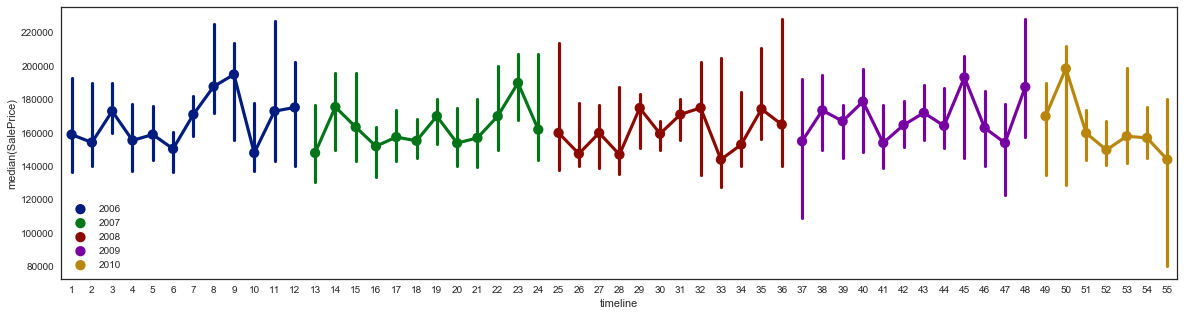

In [13]:
from numpy import median
plt.figure(figsize = (20, 5))
sns.pointplot(x = "timeline", y = "SalePrice", data = inspectTimeline, hue="YrSold", estimator = median)
plt.legend()
plt.show()

#### Other Engineered Variables: Total Square-Footage, Total Full Baths, Total Half Baths, and Deck Square-Footage


In [14]:
# Total square-footage of home, including basement sq-footage. 
homePrices["totalSqft"] = homePrices["GrLivArea"] + homePrices["TotalBsmtSF"]

#Total Full and Half Baths
homePrices["totalFullBath"] = homePrices["BsmtFullBath"] + homePrices["FullBath"] 
homePrices["totalHalfBath"] = homePrices["BsmtHalfBath"] + homePrices["HalfBath"]

# Deck Square-Footage
homePrices["deckPorchSqft"] = (homePrices["WoodDeckSF"] + homePrices["OpenPorchSF"] + 
                           homePrices["EnclosedPorch"] + homePrices["3SsnPorch"] + 
                           homePrices["ScreenPorch"])

homePricesCleaned = homePrices

In [15]:
homePricesWithDummies = pd.get_dummies(data = homePrices)

# The MSSubClass variable has several numerical values, however each signify a different categorical class. 
# Get dummy variables for the MS SubClass variables. 
homePricesMSDummies = pd.get_dummies(data=homePrices["MSSubClass"])
frames = [homePricesWithDummies, homePricesMSDummies]
homePricesWithDummies = pd.concat(frames, axis = 1)
len(homePricesWithDummies)

2919

### Filtering
We now filter based on how well the variable correlates with Sale Price. We split the training and test sets at this point, and reintroduce SalePrice to the training dataset. 

In [16]:
# Rebuild training set
training_cleaned = homePricesWithDummies[homePricesWithDummies["Group_train"]==1]
training_cleaned["loggedSalePrice"] = logged_label 

# Rebuild test set
test_cleaned = homePricesWithDummies[homePricesWithDummies["Group_test"]==1]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


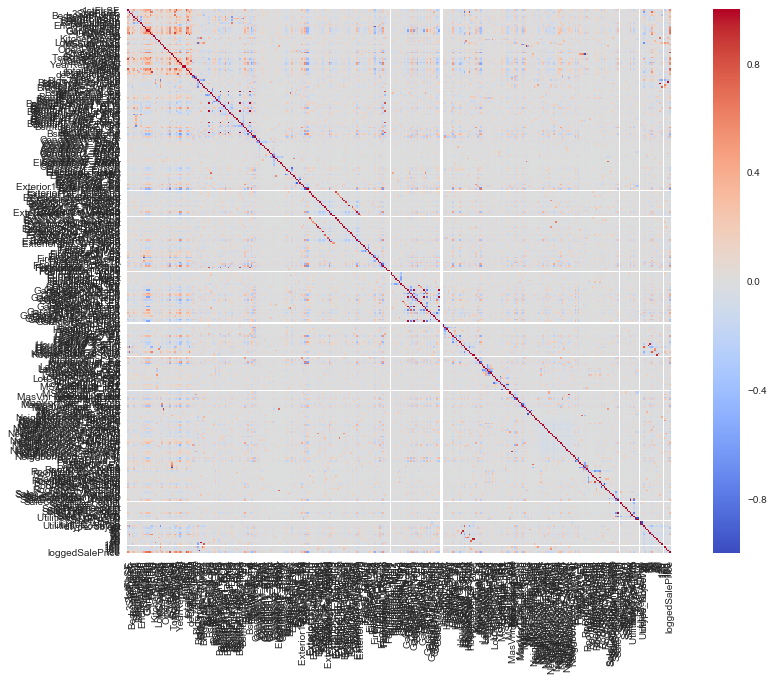

In [17]:
plt.figure(figsize = (15,5))
bigger_vars_of_interest = training_cleaned.columns

# Correlation matrix of numerical features
corrmat = training_cleaned[bigger_vars_of_interest].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax = .8, square = True, cmap = 'coolwarm')
plt.show()

In [18]:
best_features001 = corrmat[corrmat["loggedSalePrice"] >= 0.0001]
best_features001 = list(best_features001.index)
best_features = corrmat[corrmat["loggedSalePrice"] >= 0.10]
best_features = list(best_features.index)
best_features

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFullBath',
 'BsmtUnfSF',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'HalfBath',
 'LotArea',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallQual',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'totalSqft',
 'totalFullBath',
 'totalHalfBath',
 'deckPorchSqft',
 'Alley_None',
 'BldgType_1Fam',
 'BsmtCond_Gd',
 'BsmtCond_TA',
 'BsmtExposure_Av',
 'BsmtExposure_Gd',
 'BsmtFinType1_GLQ',
 'BsmtFinType2_Unf',
 'BsmtQual_Ex',
 'BsmtQual_Gd',
 'CentralAir_Y',
 'Condition1_Norm',
 'Electrical_SBrkr',
 'ExterCond_TA',
 'ExterQual_Ex',
 'ExterQual_Gd',
 'Exterior1st_VinylSd',
 'Exterior2nd_VinylSd',
 'Fence_None',
 'FireplaceQu_Ex',
 'FireplaceQu_Gd',
 'FireplaceQu_TA',
 'Foundation_PConc',
 'Functional_Typ',
 'GarageCond_TA',
 'GarageFinish_Fin',
 'GarageFinish_RFn',
 'GarageQual_TA',
 'GarageType_Attchd',
 'GarageType_BuiltIn',
 'Heating_GasA',
 'HeatingQC_Ex',

In [19]:
best_neg_features001 = corrmat[corrmat["loggedSalePrice"] <= -0.0001]
best_neg_features001 = list(best_neg_features001.index)
best_neg_features = corrmat[corrmat["loggedSalePrice"] <= -0.10]
best_neg_features = list(best_neg_features.index)
best_neg_features

['EnclosedPorch',
 'KitchenAbvGr',
 'Alley_Grvl',
 'BldgType_2fmCon',
 'BldgType_Duplex',
 'BldgType_Twnhs',
 'BsmtCond_Fa',
 'BsmtCond_None',
 'BsmtExposure_No',
 'BsmtExposure_None',
 'BsmtFinType1_BLQ',
 'BsmtFinType1_None',
 'BsmtFinType1_Rec',
 'BsmtFinType2_None',
 'BsmtQual_Fa',
 'BsmtQual_None',
 'BsmtQual_TA',
 'CentralAir_N',
 'Condition1_Artery',
 'Condition1_Feedr',
 'Electrical_FuseA',
 'Electrical_FuseF',
 'ExterCond_Fa',
 'ExterQual_Fa',
 'ExterQual_TA',
 'Exterior1st_AsbShng',
 'Exterior1st_MetalSd',
 'Exterior1st_Wd Sdng',
 'Exterior2nd_AsbShng',
 'Exterior2nd_MetalSd',
 'Exterior2nd_Wd Sdng',
 'Fence_GdWo',
 'Fence_MnPrv',
 'FireplaceQu_None',
 'Foundation_BrkTil',
 'Foundation_CBlock',
 'Foundation_Slab',
 'Functional_Maj2',
 'GarageCond_Fa',
 'GarageCond_None',
 'GarageFinish_None',
 'GarageFinish_Unf',
 'GarageQual_Fa',
 'GarageQual_None',
 'GarageType_Detchd',
 'GarageType_None',
 'Heating_Grav',
 'HeatingQC_Fa',
 'HeatingQC_Gd',
 'HeatingQC_TA',
 'HouseStyle_1.5F

In [20]:
all_best_features = best_features + best_neg_features
all_best_features001 = best_features001 + best_neg_features001

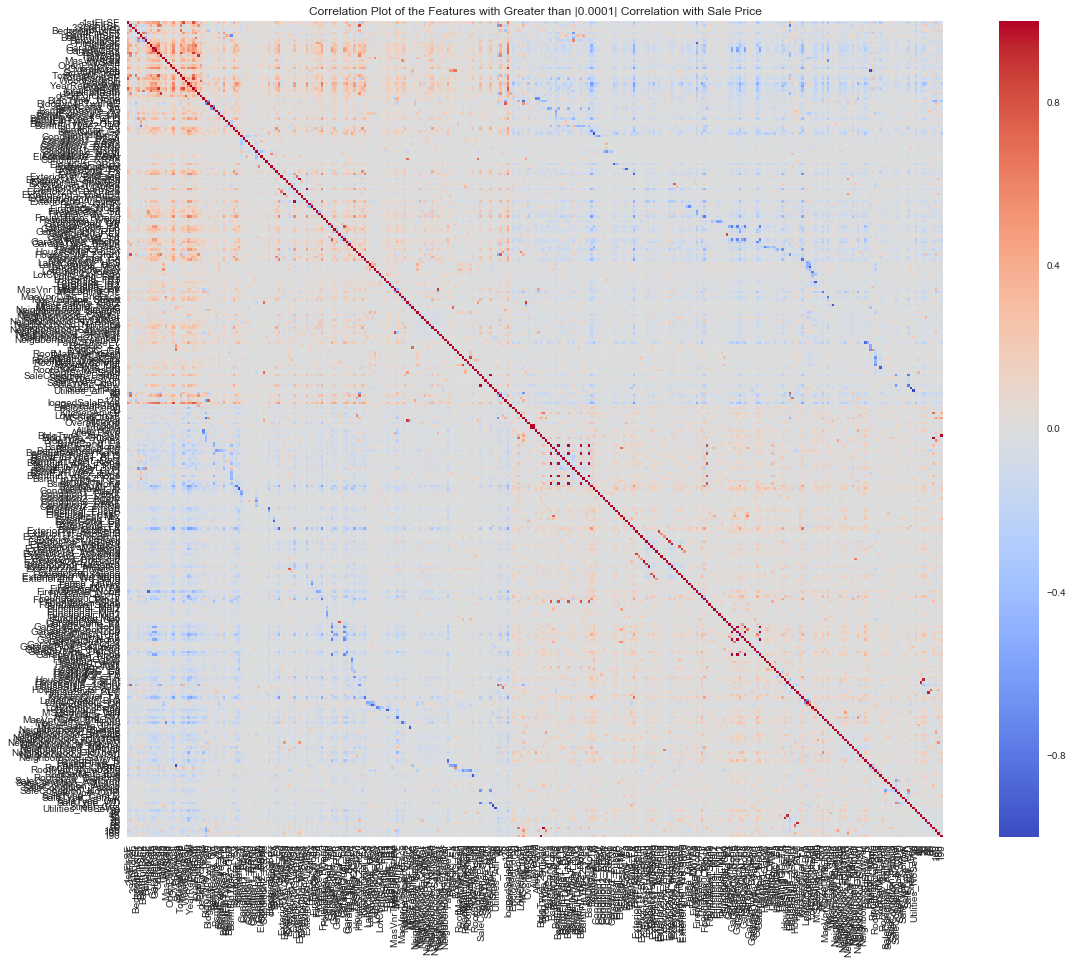

In [21]:
# Correlation matrix of numerical features
corrmat = training_cleaned[all_best_features001].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (20, 15))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax = .8, square = True, annot = False, cmap = 'coolwarm')
plt.title("Correlation Plot of the Features with Greater than |0.0001| Correlation with Sale Price")
plt.show()


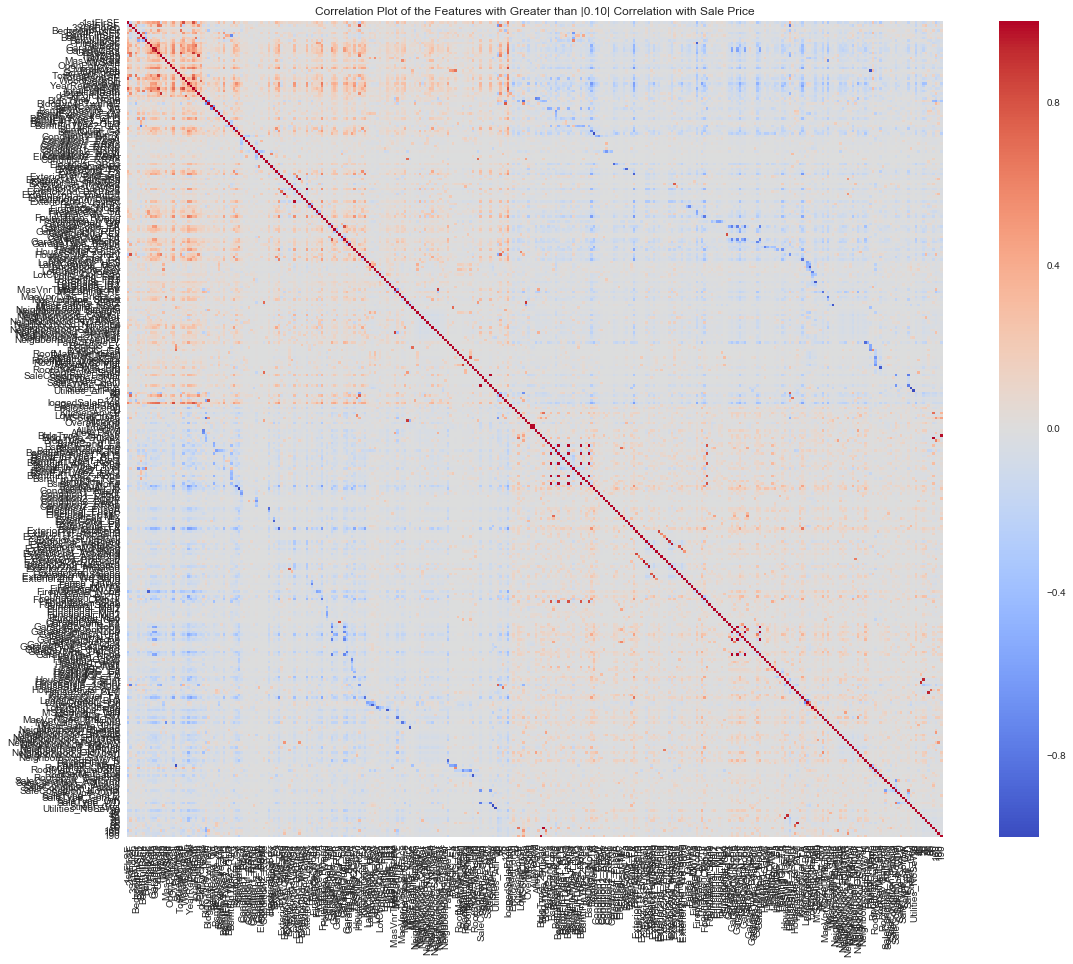

In [22]:
# Correlation matrix of numerical features
corrmat2 = training_cleaned[all_best_features].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (20, 15))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax = .8, square = True, annot = False, cmap = 'coolwarm')
plt.title("Correlation Plot of the Features with Greater than |0.10| Correlation with Sale Price")
plt.show()


### Find the optimal degree of correlation for inclusion in Linear Models

In [23]:
interval = 0.01
corr_range = np.arange(0,.8,interval)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwar

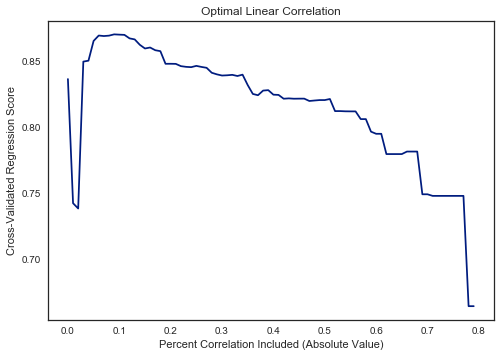

The optimal variables for inclusion in the Linear Model is those with correlation of corr = |0.09| and greater.


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score

regr = linear_model.LinearRegression()

# search for an optimal correlation value for Linear Models
corr_scores = []
for corrVal in corr_range: 

    best_features = corrmat[corrmat["loggedSalePrice"] >= corrVal]
    best_features = list(best_features.index)
    best_neg_features = corrmat[corrmat["loggedSalePrice"] <= -corrVal]
    best_neg_features = list(best_neg_features.index)
    current_best_features = best_features + best_neg_features
    current_best_features.remove("loggedSalePrice")
    current_training_cleaned = training_cleaned.drop("loggedSalePrice", axis=1)
    current_training_cleaned.head()
    Y = logged_label
    X = current_training_cleaned[current_best_features]
    
    regr_score = cross_val_score(regr, X, Y, cv=10)
    corr_scores.append(regr_score.mean())

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(corr_range, corr_scores)
plt.xlabel("Percent Correlation Included (Absolute Value)")
plt.ylabel("Cross-Validated Regression Score")
plt.legend()
plt.title("Optimal Linear Correlation")
plt.show()

print("The optimal variables for inclusion in the Linear Model is those with correlation of " 
      "corr = |{}| and greater.".format(corr_scores.index(max(corr_scores))*interval))
max_linear = corr_scores.index(max(corr_scores))*interval

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to une

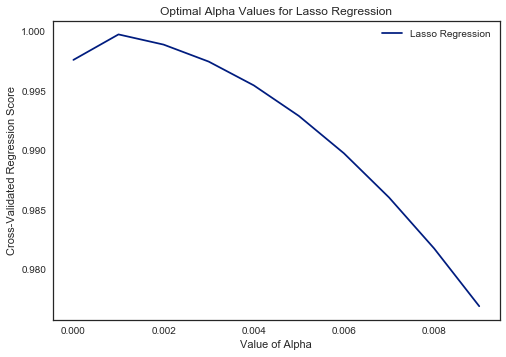

The optimal value for alpha in Lasso Regression is 0.001. 


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

interval = 0.001
alpha_range = np.arange(0,0.01,interval)
   
Y = logged_label
X = training_cleaned[all_best_features001]

# search for an optimal correlation value for Linear Models
lasso_scores = []
for alphaVal in alpha_range: 
    lassBig = linear_model.Lasso(alpha=alphaVal)
    lasso_score = cross_val_score(lassBig, X, Y, cv=10)
    lasso_scores.append(lasso_score.mean())
    
# plot the performance of Lasso and Ridge Regression against the value of alpha
plt.plot(alpha_range, lasso_scores, label = "Lasso Regression")
plt.xlabel("Value of Alpha")
plt.ylabel("Cross-Validated Regression Score")
plt.legend()
plt.title("Optimal Alpha Values for Lasso Regression")
plt.show()

print("The optimal value for alpha in Lasso Regression is {}. ".format(lasso_scores.index(max(lasso_scores))*interval))
best_alpha = lasso_scores.index(max(lasso_scores))*interval


In [26]:
# Determined by running a deep and intensive search using the following parameters: 
# interval = 0.00001
# alpha_range = np.arange(0,0.005,interval)
# best_alpha = lasso_scores.index(max(lasso_scores))*interval
# Takes ~30 mins to run. 
# max(lasso_scores) = 0.87837143492500525

best_alpha_for_Lasso = 0.0006000


During the modelling phase, we can't include the "SalePrice" feature in our model except as the target variable. 


In [27]:
all_best_features001.remove("loggedSalePrice")
all_best_features.remove("loggedSalePrice")
del training_cleaned["loggedSalePrice"]


# Generating Predictive Models

## Linear Regression

In [28]:
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score

# Takes the best value from the previous optimization exercise on the correlation value, and 
# applies it to this model. 
linear_best_features = list((corrmat[corrmat["loggedSalePrice"] >= max_linear]).index) + list(
    (corrmat[corrmat["loggedSalePrice"] <= -max_linear]).index)
linear_best_features.remove("loggedSalePrice")

regr = linear_model.LinearRegression()
Y = logged_label
X = training_cleaned[linear_best_features]
regr.fit(X, Y)

# Inspect the results.
#print('\nCoefficients: \n', regr.coef_)
#print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


R-squared:
0.913812882494


In [29]:
from sklearn.model_selection import cross_val_score

Y = logged_label
X = training_cleaned[linear_best_features]

regr_score = cross_val_score(regr, X, Y, cv=10)
print("Cross-Validated R-Squared of Linear Regression Model: %0.2f (+/- %0.2f)" 
      % (regr_score.mean(), regr_score.std() * 2))

Cross-Validated R-Squared of Linear Regression Model: 0.87 (+/- 0.12)


## LASSO Regression

In [30]:
from sklearn import linear_model
Y = logged_label
X = training_cleaned[all_best_features001]

lassolm = linear_model.Lasso(alpha=best_alpha_for_Lasso, max_iter=10000)
lassolm_score = cross_val_score(lassolm, X, Y, cv=10)
print("Cross-Validated R-Squared of Linear Regression Model: %0.2f (+/- %0.2f)" 
      % (lassolm_score.mean(), lassolm_score.std() * 2))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/pyth

Cross-Validated R-Squared of Linear Regression Model: 0.88 (+/- 0.18)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## K-Nearest Neighbors

### Find an optimal k-value by iterating over each value of k

In [31]:
Y = logged_label
X = stats.zscore(training_cleaned[all_best_features])

# search for an optimal unweighted value of K for KNN
k_range = range(1,20)
k_scores = []
for k in k_range: 
    knn = neighbors.KNeighborsRegressor(n_neighbors = k)
    scores = cross_val_score(knn, X, Y, cv = 10)
    k_scores.append(scores.mean())

# search for an optimal weighted value of K for KNN
k_range = range(1,20)
k_scores_w = []
for k in k_range: 
    knn_w = neighbors.KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    scores_w = cross_val_score(knn_w, X, Y, cv = 10)
    k_scores_w.append(scores_w.mean())


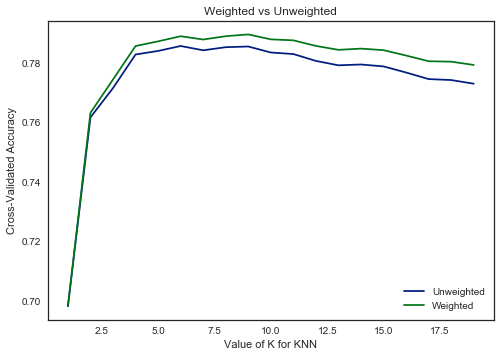

The optimal value for k (unweighted) is k=6
The optimal value for k (weighted by distance) is k=6


In [32]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores, label="Unweighted")
plt.plot(k_range, k_scores_w, label="Weighted")
plt.xlabel("Value of K for KNN")
plt.ylabel("Cross-Validated Accuracy")
plt.legend()
plt.title("Weighted vs Unweighted")
plt.show()

print("The optimal value for k (unweighted) is k={}".format(k_scores.index(max(k_scores))+1))
print("The optimal value for k (weighted by distance) is k={}".format(k_scores.index(max(k_scores))+1))

In [33]:
# Unweighted KNN (Cross-Validated)
knn = neighbors.KNeighborsRegressor(n_neighbors = 8)
knn_score = cross_val_score(knn, X, Y, cv = 10)
print("KNN Unweighted Mean Score: %0.2f (+/- %0.2f)" % (knn_score.mean(), knn_score.std() * 2))

# Weighted KNN (Cross-Validated)
knn_w = neighbors.KNeighborsRegressor(n_neighbors = 8, weights = 'distance')
knn_w_score = cross_val_score(knn_w, X, Y, cv = 10)
print("KNN Weighted Mean Score: %0.2f (+/- %0.2f)" % (knn_w_score.mean(), knn_w_score.std() * 2))

KNN Unweighted Mean Score: 0.79 (+/- 0.06)
KNN Weighted Mean Score: 0.79 (+/- 0.05)


## Random Forest Regression

In [34]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 500)
X = pd.DataFrame(training_cleaned[all_best_features])
Y = logged_label

rfr_score = cross_val_score(rfr, X, Y, cv = 10)
print("Random Forest: %0.2f (+/- %0.2f)" % (rfr_score.mean(), rfr_score.std() * 2))


Random Forest: 0.88 (+/- 0.04)


## Decision Tree with AdaBoost 

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

X = pd.DataFrame(training_cleaned[all_best_features001])
Y = logged_label

# Fit regression model
ada_regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 5),
                          n_estimators = 600)

ada_regr_score = cross_val_score(ada_regr, X, Y, cv=10)
print("Decision Tree Regression With AdaBoost: %0.2f (+/- %0.2f)" % (ada_regr_score.mean(), ada_regr_score.std() * 2))


KeyboardInterrupt: 

## Gradient Boosting Regression

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

X = training_cleaned[linear_best_features]
y = logged_label

gb_regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,
    max_depth=4, loss='ls')

gb_regr_score = cross_val_score(gb_regr, X, y, cv=10)
print("Gradient Boost Regression: %0.2f (+/- %0.2f)" % (gb_regr_score.mean(), gb_regr_score.std() * 2))


## Model Comparision and Discussion

In [ ]:
scores = pd.DataFrame()
scores["Gradient Boost Regression"] = gb_regr_score
scores["Lasso Regression"] = lassolm_score
scores["Random Forest"] = rfr_score
scores["Linear Regression"] = regr_score
scores["Decision Tree with AdaBoost"] = ada_regr_score
scores["Weighted KNN"] = knn_w_score
scores["K-Nearest Neighbors (KNN)"] = knn_score

results = pd.DataFrame()
results["Model"] = ("Linear Regression", "K-Nearest Neighbors (KNN)", "Weighted KNN", "Random Forest", 
                    "Decision Tree with AdaBoost", "Gradient Boost", "LASSO Regression")

results["Score"] = (regr_score.mean(), knn_score.mean(), knn_w_score.mean(), rfr_score.mean(), 
                    ada_regr_score.mean(), gb_regr_score.mean(), lassolm_score.mean())
results["Standard Deviation"] = (regr_score.std(), knn_score.std(), knn_w_score.std(), rfr_score.std(), 
                                 ada_regr_score.std(), gb_regr_score.std(), lassolm_score.std())


results

In [ ]:
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.barplot(data=scores)
plt.xlabel("Model")
plt.ylabel("Cross-Validated Score")
plt.title("Comparison of Performance Across Predictive Models")
plt.show()

## Interpretation

Each strategy for modelling and predicting data has it's advantages and disadvantages. The goal is to find the method that can most accurately predict the outcome of interest, in this case the Sale Price of the home. 

The **Gradient Boost** and **AdaBoost** algorithms were among the best overall performers in this study. Their high score and low variances make them great predictive models. Disadvantages with boosting models are that they are 'black box' models, and so it can be hard to determine which variables are having the most effect on the outcome, and there may be slight variations in results between runs. Variations can be limited by running a high volume of iterations.  

The **Random Forest Regression** is an ensemble method that helps to improve the outcome from Decision Trees by reducing overfitting. Many trees are created (making a forest, if you will). Each decision tree is seeded with slightly different parameters, and each tree votes for an outcome. The Random Forest performance was high, with low variance. 

The **Linear Regression** and **Lasso Regression** models score well, however the variance is high in both cases compared to the boosting and ensemble models. This is because only one model is created, compared to boosting and ensemble models where hundreds or even thousands of models are created and combined. The best advantage to Linear and LASSO regressions is that one can obtain coefficients which are easily interpretable to decision-makers. LASSO is an especially good option for datasets with large numbers of variables.  

The **K-Nearest Neighbors Regression** models (Weighted and Unweighted) did not score as well for this dataset, however the variance between cross-validated folds is small. There may be other situations where KNN is a better performer, but it will not be included in our final prediction for this dataset. 


# Methods for Further Optimization: 

## Dimensionality Reduction via PCA*

**\*aka Principle Components Analysis**

Principle Components Analysis utilizes linear combinations of the original variables such that the first principal component explains the largest variance between the variables, the second explains the next largest variance, etc. The principal components are uncorrelated to each other, and each successive component explains less and less variability. 

The first *eigenvalue* explains the largest amount of variance, the second explains the second largest, etc. 
As we reduce the dimensionality of the data, the goal is to capture the most variance in the fewest number of *eigenvalues*. This can be intuitively viewed in a scree plot. 


In [ ]:
# Turn variable string values into integer values
homePrices_with_dummies = pd.get_dummies(data = homePricesCleaned)

# Log transform
logged_homePrices_with_dummies = np.log(homePrices_with_dummies)

# Remove -infs in the dataset
logged_homePrices_with_dummies[logged_homePrices_with_dummies==-np.inf] = 0

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40, whiten=True)
a = pca.fit(logged_homePrices_with_dummies)
variance = pd.DataFrame(pca.explained_variance_ratio_)



In [ ]:
plt.figure(1, figsize=(9, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])

dat = range(1, 41)
plt.plot(dat, variance, marker='o')

plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance')
plt.title("Scree Plot Showing Percent Variability Explained by Each Eigenvalue")

plt.show()

n_var = float(list(variance[:7].sum())[0])
print("The first 7 components can explain {}% of the variance in the data.".format(n_var *100//1))

n_var = float(list(variance[:13].sum())[0])
print("Just eleven principal components can explain {}% of the variance in the data.".format(n_var *100//1))

We see that we can reduce the dimensionality of our dataset using Principal Component Analysis. The 82 variables included in the original dataset can be reduced to 11 components to explain 95.0% of the variances in the Sales Price. 

### PCA Plot and Label Creation: 

Let's visualize the stratification in the data separating upper half and lower half of homes using a PCA plot. 


In [ ]:
label.describe()

Let's explore what makes a home sell in the top half versus the bottom half. Class1 includes homes which sold for more than \$163k, and Class2 sold for \$163k or less. 



In [ ]:
class1 = label[label > 163000]
class2 = label[label <= 163000]


print(len(class1))
print(len(class2))

In [ ]:
# Transpose the class labels
class1T = class1.T
class2T = class2.T

pca = PCA(n_components=2, whiten=True)
transf = pca.fit_transform(logged_homePrices_with_dummies)
transf_label = label.T


In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(transf[class1T.index,0],transf[class1T.index,1], 'o', 
         markersize=7, color='blue', alpha=0.5, 
         label='Top 50% of Homes by Sales Price')
plt.plot(transf[class2T.index,0],transf[class2T.index,1], '^', 
         markersize=7, color='green', alpha=0.5, 
         label='Bottom 50% of Homes by Sales Price')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.legend()
plt.title("PCA Plot of Homes Prices Data")
plt.show()

PCA is useful for reducing the dimensionality of the data. Above, the first two PCA components (aka *eigenvectors*) show differences in the two groupings of homes. Each PCA component is by definition uncorrelated to other PCA components, which makes this analysis well-suited to use with Linear Regression. One basic assumption of Linear Regression is that all variables are uncorrelated to each other. Let's see if we can improve on our existing Linear Regression Model using PCA. 

In [ ]:
pca = PCA(n_components=100, whiten=True)
a = pca.fit(logged_homePrices_with_dummies)
variance = pd.DataFrame(pca.explained_variance_ratio_)

X_pca = pca.fit_transform(X)

regr.fit(X_pca, Y)
score = cross_val_score(regr, X_pca, Y, cv=10)
print("Cross-Validated R-Squared of Linear Regression Model: %0.2f (+/- %0.2f)" 
      % (score.mean(), score.std() * 2))


In [ ]:
pca = PCA(n_components=50, whiten=True)
a = pca.fit(logged_homePrices_with_dummies)
variance = pd.DataFrame(pca.explained_variance_ratio_)

X_pca = pca.fit_transform(X)

regr.fit(X_pca, Y)
score = cross_val_score(regr, X_pca, Y, cv=10)
print("Cross-Validated R-Squared of Linear Regression Model: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


In [ ]:
pca = PCA(n_components=20, whiten=True)
a = pca.fit(logged_homePrices_with_dummies)
variance = pd.DataFrame(pca.explained_variance_ratio_)

X_pca = pca.fit_transform(X)

regr.fit(X_pca, Y)
score = cross_val_score(regr, X_pca, Y, cv=10)
print("Cross-Validated R-Squared of Linear Regression Model: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


## Results of PCA

PCA Analysis allows an analyst to lessen the computational requirements by reducing the number of variables in the dataset. In this dataset we reduced from 2,919 variables to only 100 variables or less, with little drop in performance in the Linear Regression Model. 

This dataset is small enough that PCA is not necessary. However, there are situations where PCA becomes exceedingly important, especially when data arrives as Gigabytes or Terabytes and computational efficiency is of utmost importance. 

# Combine Best Models and Apply to the Test Set

The best performing models can now be combined to create an optimized model. Each model has certain biases, or "blind spots". We combine models built from multiple methods in order to offset biases within each model.


In [ ]:
# Top Performing Models
gb_regr.fit(training_cleaned[linear_best_features],Y)
lassolm.fit(training_cleaned[all_best_features001],Y)
rfr.fit(training_cleaned[all_best_features001],Y)
regr.fit(training_cleaned[linear_best_features],Y)
ada_regr.fit(training_cleaned[all_best_features001],Y)

gb_pred = gb_regr.predict(X=test_cleaned[linear_best_features])
lasso_pred = lassolm.predict(X=test_cleaned[all_best_features001])
rfr_pred = rfr.predict(X=test_cleaned[all_best_features001])
regr_pred = regr.predict(X=test_cleaned[linear_best_features])
ada_pred = ada_regr.predict(X=test_cleaned[all_best_features001])

# Take the average of the logged predictions, then return to exponential form.
prediction = np.exp((gb_pred + lasso_pred + rfr_pred + regr_pred + ada_pred) / 5)
predictions = pd.DataFrame(prediction, index = test_cleaned["Id"], columns=["SalePrice"])

# Name output file
predictions.to_csv('/Users/jacquelynzuker/Desktop/rfr_gb_lasso_regr_ada_averaged3.csv')